In [1]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
from resnet import resnet50
from deepdream import dream
from numpy import linalg as LA
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [3]:
w, h = 64, 64
#data = np.zeros((h, w, 3), dtype=np.uint8)
data = np.random.randint(0, 255, size=(w, h, 3), dtype=np.uint8)
img = Image.fromarray(data, 'RGB')
img.save('input.png')
#img.show()

In [4]:
input_img = Image.open('./input.png')
input_tensor = img_transform(input_img).unsqueeze(0)
input_np = input_tensor.numpy()

In [5]:
input_tensor.shape

torch.Size([1, 3, 64, 64])

In [6]:
# input_img = Image.open('./sky.jpg')
# input_tensor = img_transform(input_img).unsqueeze(0)
# input_np = input_tensor.numpy()
# input_tensor.shape

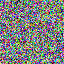

In [7]:
input_img

In [8]:
# load model
model = resnet50(pretrained=True)
if torch.cuda.is_available():
    model = model.cuda()
for param in model.parameters():
    param.requires_grad = False

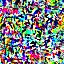

In [9]:
out = dream(model, input_np, 1)

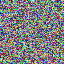

In [10]:
dream_img = Image.fromarray(np.reshape(out[0], (64, 64, 3)), 'RGB')
#dream_img.save('dream_out.png')
dream_img

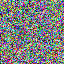

In [11]:
Image.fromarray(np.reshape(out[0], (64, 64, 3))-np.reshape(input_tensor[0].numpy(), (64, 64, 3)), 'RGB')

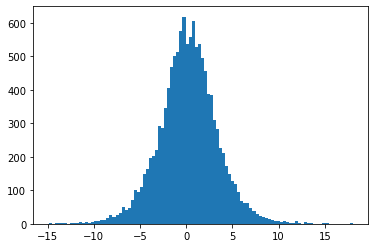

In [12]:
_=plt.hist(np.reshape(out, -1), bins=100)

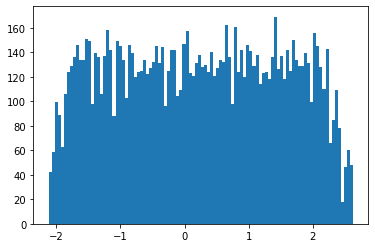

In [13]:
_=plt.hist(np.reshape(input_tensor[0].numpy(), -1), bins=100)

In [14]:
np.mean(np.reshape(out, -1))

0.22008105

In [15]:
np.mean(np.reshape(input_tensor[0].numpy(), -1))

0.21819627

# Driving by class id of imagenet's 1000 outputs

In [16]:
in_noise=0*np.random.rand(1000)
l1=np.sum(in_noise)
in_noise=in_noise
in_noise[100]=3
inputs_control = torch.tensor(in_noise)

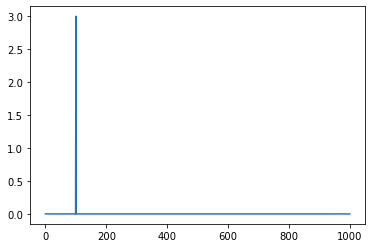

In [17]:
plt.plot(in_noise)

In [18]:
w, h = 64, 64
#data = np.zeros((h, w, 3), dtype=np.uint8)
data_guide = np.random.randint(0, 255, size=(w, h, 3), dtype=np.uint8)
guide = Image.fromarray(data_guide, 'RGB')
guide.save('guide.png')
#img.show()

In [19]:
img_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])




In [20]:
guide_img = Image.open('./guide.png')
guide_tensor = img_transform(guide_img).unsqueeze(0)


In [21]:
if torch.cuda.is_available():
    x_variable = Variable(guide_tensor.cuda())
else:
    x_variable = Variable(guide_tensor)

control_features = model.forward(x_variable)

In [45]:
def objective_guide(dst, guide_features):
    x = dst.data[0].cpu().numpy().copy()
    y = guide_features.data[0].cpu().numpy()
    #ch, w, h = x.shape
    #x = x.reshape(ch,-1)
    #y = y.reshape(ch,-1)
    A=x-y
    A[100]=10*y[100]
    # max_class=A.argmax()
    # A = x.T.dot(y) # compute the matrix of dot-products with guide features
    # result = y[:,A.argmax(1)] # select ones that match best
    # result = torch.Tensor(np.array([result.reshape(ch, w, h)], dtype=np.float)).cuda()
    # return result
    out=torch.Tensor(np.array([A], dtype=np.float))
    return out

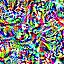

In [46]:
out_guide=dream(model, input_np, 100, control=control_features, distance=objective_guide)

In [63]:
pred=model.forward(torch.Tensor(out_guide))

In [64]:
pred=pred.cpu().numpy()[0]

In [50]:
np.argmax(pred)

463

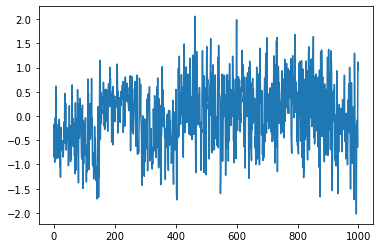

In [68]:
plt.plot(pred)

In [52]:
pred_in=model.forward(torch.Tensor(input_tensor))
pred_in=pred_in.cpu().numpy()[0]

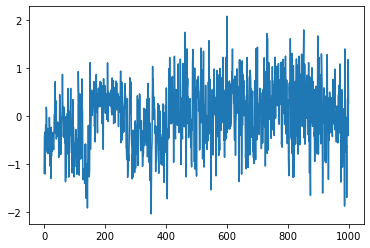

In [53]:
plt.plot(pred_in)

In [54]:
np.mean(out-out_guide)

0.0043067257

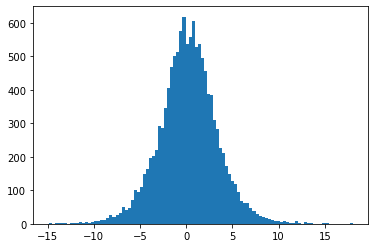

In [55]:
_=plt.hist(np.reshape(out, -1), bins=100)

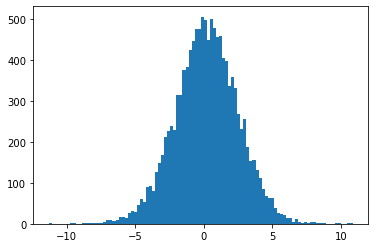

In [56]:
_=plt.hist(np.reshape(out_guide, -1), bins=100)